# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [543]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [648]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', ';')

In [649]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [650]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [651]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [652]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [653]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [654]:
feat_info.isnull().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

In [655]:
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,0,9]     1
[XX]         1
[-1,XX]      1
Name: missing_or_unknown, dtype: int64

In [656]:
feat_info[feat_info.missing_or_unknown == '[XX]']

,attribute,information_level,type,missing_or_unknown
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]


In [657]:
feat_info[feat_info.missing_or_unknown == '[-1,X]']

,attribute,information_level,type,missing_or_unknown
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]"


In [658]:
feat_info[feat_info.missing_or_unknown == '[-1,XX]']

,attribute,information_level,type,missing_or_unknown
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [659]:
def convert_to_list_for_X_or_XX(s):
    if 'XX' in s:
        if len(s) == 4:
            return [s[1:-1]]
        else:
            return [-1, 'XX']
    elif 'X' in s:
        return [-1, 'X']
    else:
        return eval(s)

In [660]:
feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(convert_to_list_for_X_or_XX)
missing_data = dict(zip(feat_info.attribute, feat_info.missing_or_unknown))

In [661]:
missing_data['AGER_TYP']

[-1, 0]

In [662]:
for col in missing_data.keys():
    nans_before = azdias[col].isnull().sum()
    azdias.loc[azdias[col].isin(missing_data[col]), col] = np.nan
    nans_after = azdias[col].isnull().sum()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [663]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [664]:
azdias_missing = azdias.isnull().sum()
azdias_missing_percentage = (azdias.isnull().sum())/891221

In [665]:
azdias_missing_percentage.head()

AGER_TYP                0.769554
ALTERSKATEGORIE_GROB    0.003233
ANREDE_KZ               0.000000
CJT_GESAMTTYP           0.005446
FINANZ_MINIMALIST       0.000000
dtype: float64

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([      0. ,   88906.1,  177812.2,  266718.3,  355624.4,  444530.5,
         533436.6,  622342.7,  711248.8,  800154.9,  889061. ]),
 <a list of 10 Patch objects>)

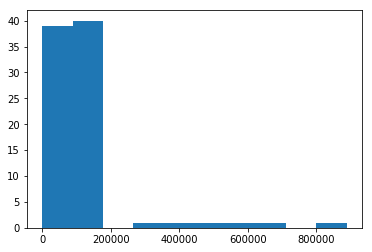

In [666]:
# Investigate patterns in the amount of missing data in each column.

azdias_missing = azdias.isnull().sum()

plt.hist(azdias_missing)

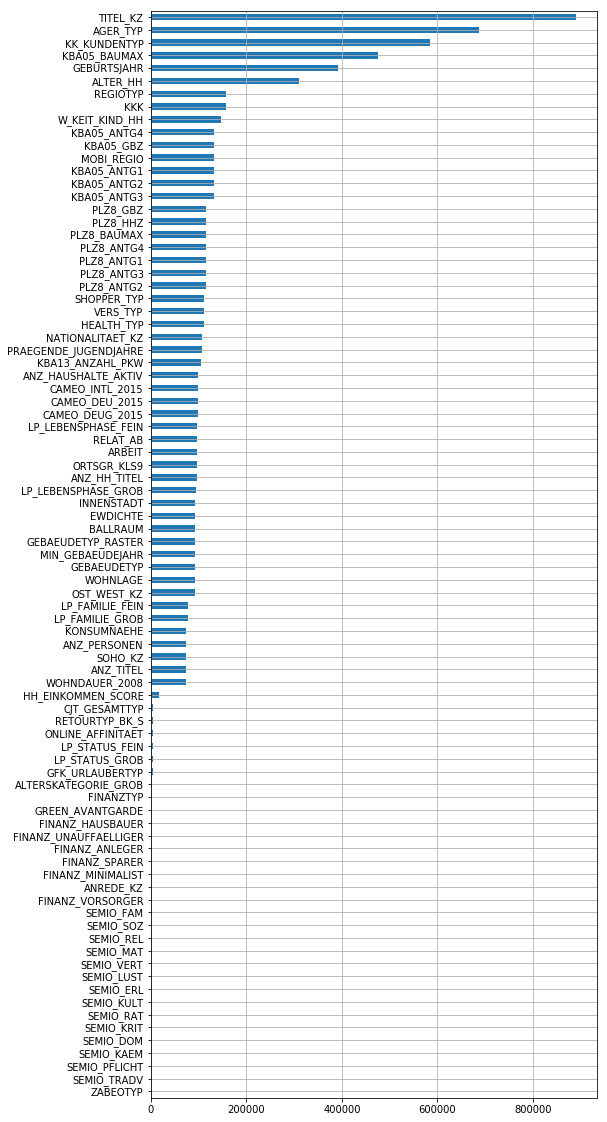

In [667]:
azdias_plot= azdias_missing.sort_values(ascending=True)
azdias_plot.plot.barh(figsize=(8, 20), grid=True)

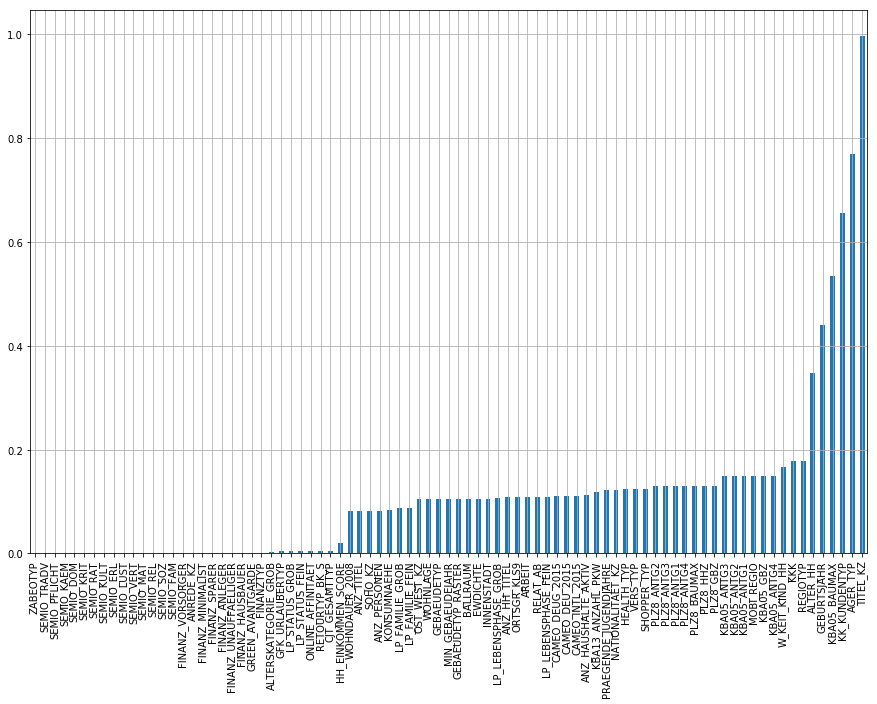

In [668]:
azdias_plot1= azdias_missing_percentage.sort_values(ascending=True)
azdias_plot1.plot.bar(figsize=(15,10), grid=True)

In [669]:
drop_selected_columns = [col for col in azdias.columns if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > 15]
drop_selected_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'W_KEIT_KIND_HH',
 'KBA05_BAUMAX',
 'KKK',
 'REGIOTYP']

In [670]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

for col in drop_selected_columns:
    azdias.drop(col, axis=1, inplace=True)

In [671]:
azdias.shape

(891221, 76)

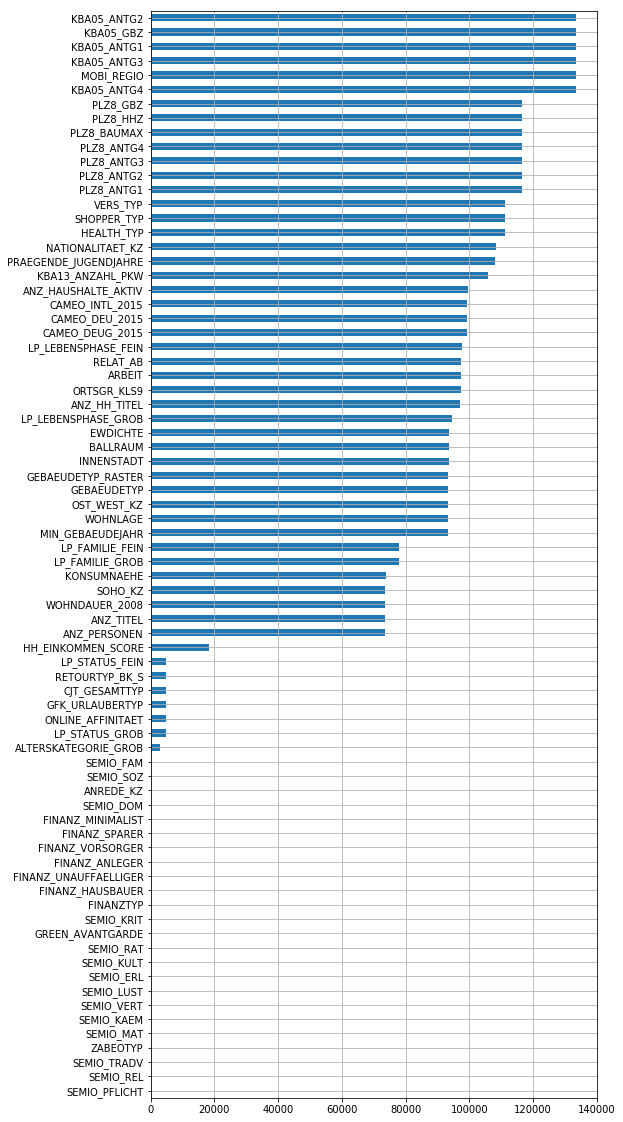

In [672]:
azdias_plot2= azdias.isnull().sum().sort_values(ascending=True)
azdias_plot2.plot.barh(figsize=(8, 20), grid=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

As we can see in the graph and the analysis I have done, within the initial 85 columns, only 24 columns do not have missing data, the rest 72% of the columns contain the missing data. There are some columns have huge amount of missing data. TITEL_KZ is almost missing all the data, Ager_type has around 78% of missing data, KK_KUNDENTYP has around 65%, KBA_BAUMAX has 52%, GEBURTSJAHR has 45%, ALTER_HH has around 33%. The amount of missing data of these columns has a big difference from the rest, we can consider them as the outliers. I definitely dropped them for having a cleaner dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [673]:
# How much data is missing in each row of the dataset?

azdias_clean = azdias.isnull().sum(axis=1)
azdias_clean

0         40
1          0
2          0
3          4
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        44
12         6
13         6
14        44
15         8
16         5
17        44
18         0
19         0
20         8
21         0
22         0
23         8
24        44
25         4
26        17
27         0
28         0
29         0
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    11
891204     0
891205     0
891206     0
891207     0
891208     0
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     4
891219     0
891220     0
Length: 891221, dtype: int64

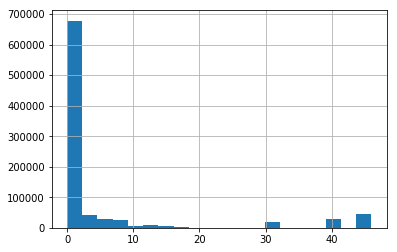

In [674]:
azdias_clean.hist(bins = 20)

In [675]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

lessthan25 = azdias[azdias.isnull().sum(axis=1) < 25].reset_index(drop=True)

morethan25 = azdias[azdias.isnull().sum(axis=1) >= 25].reset_index(drop=True)

In [676]:
lessthan25.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [677]:
lessthan25.columns[:5]

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER'],
      dtype='object')

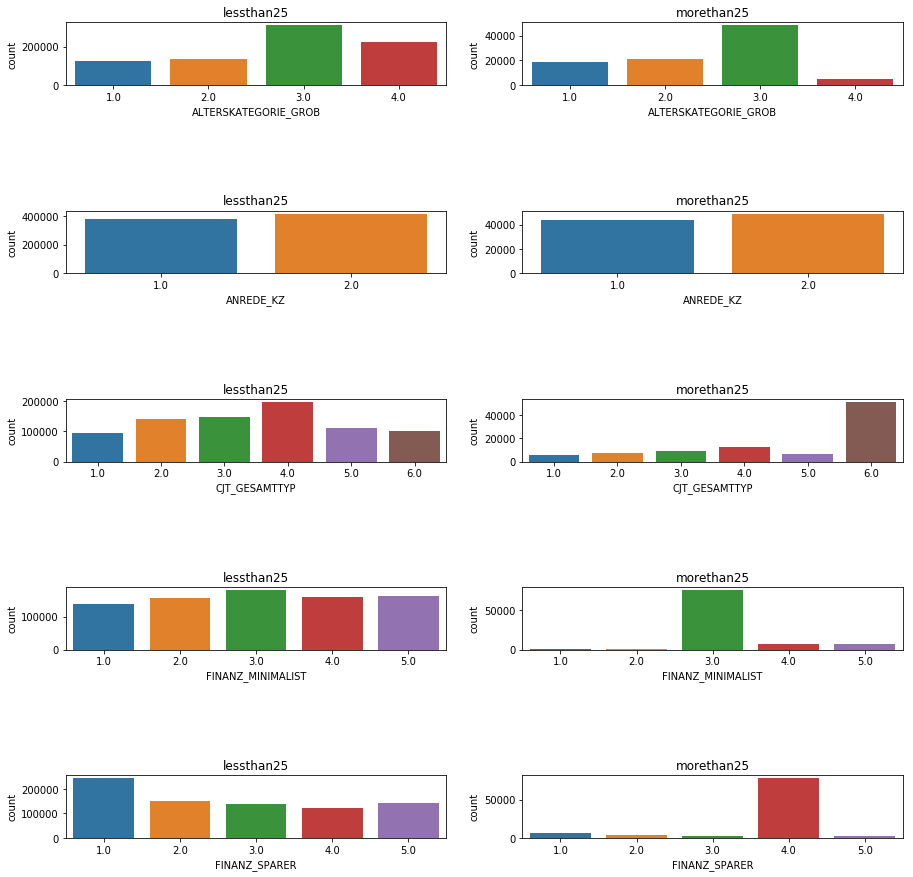

In [678]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
random_column = lessthan25.columns

def print_random_column(cols,num):
    
    fig, axs = plt.subplots(num,2, figsize=(15, 15))
    fig.subplots_adjust(hspace =2 , wspace=.2)
    axs = axs.ravel()

    for i in range(num):
    
        sns.countplot(lessthan25[cols[i]], ax=axs[i*2])
        axs[i*2].set_title('lessthan25')
        
        sns.countplot(morethan25[cols[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('morethan25')
    
    
print_random_column(random_column,5)

In [679]:
for col in lessthan25.columns:
    lessthan25[col] = lessthan25[col].fillna(lessthan25[col].mode()[0])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

In this part, we have seen the missing data in the row level. We can see from the histogram that the missing data in row have distribution into 2 partes. Almost of them are less than 25 missing data per row, the rest of them have more than 25 missing data per row. 

Then I randomly chose 5 columns to see their missing row data. We can see that some of the column have more the less the equal distribution of the data in 'less than 25 missing data' and 'more than 25 missing data'. But some of them have better distribution of data in the 'less than 25 missing data' part.

We can use the 'less than 25 missing data' group as our test data in the next modeling work. In this case, I have fill the missing data in the 'less than 25 missing data' group.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [680]:
# How many features are there of each data type?

feat_info_clean = feat_info.drop('missing_or_unknown',1)
feat_info_clean.head()

,attribute,information_level,type
0,AGER_TYP,person,categorical
1,ALTERSKATEGORIE_GROB,person,ordinal
2,ANREDE_KZ,person,categorical
3,CJT_GESAMTTYP,person,categorical
4,FINANZ_MINIMALIST,person,ordinal


In [681]:
feat_info_clean = feat_info_clean[feat_info_clean.attribute.isin(azdias.columns)]
feat_info_clean.head()

,attribute,information_level,type
1,ALTERSKATEGORIE_GROB,person,ordinal
2,ANREDE_KZ,person,categorical
3,CJT_GESAMTTYP,person,categorical
4,FINANZ_MINIMALIST,person,ordinal
5,FINANZ_SPARER,person,ordinal


In [682]:
feat_info_clean.type.value_counts()

ordinal        46
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [683]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_info_clean[feat_info_clean.type == 'categorical']


,attribute,information_level,type
2,ANREDE_KZ,person,categorical
3,CJT_GESAMTTYP,person,categorical
10,FINANZTYP,person,categorical
12,GFK_URLAUBERTYP,person,categorical
13,GREEN_AVANTGARDE,person,categorical
17,LP_FAMILIE_FEIN,person,categorical
18,LP_FAMILIE_GROB,person,categorical
19,LP_STATUS_FEIN,person,categorical
20,LP_STATUS_GROB,person,categorical
21,NATIONALITAET_KZ,person,categorical


In [684]:
feat_info_clean[feat_info_clean.type == 'categorical'].groupby('information_level').count()

,attribute,type
information_level,,
building,2,2
microcell_rr4,2,2
person,14,14


In [685]:
# Get the categorical feature names
category_feature_name = feat_info_clean[feat_info_clean.type == 'categorical'].attribute
category_feature_name

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [686]:
# Find the number of levels
azdias[category_feature_name].nunique().sort_values()

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [687]:
# how many binary
sum(azdias[category_feature_name].nunique() == 2)

5

In [688]:
# how many multilevel
sum(azdias[category_feature_name].nunique() != 2)

13

In [689]:
azdias[category_feature_name].dtypes

ANREDE_KZ           float64
CJT_GESAMTTYP       float64
FINANZTYP           float64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE    float64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
ZABEOTYP            float64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

In [690]:
azdias[category_feature_name[-3:]].head(10)

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,NaN,NaN,NaN
1,W,8,8A
2,W,4,4C
3,W,2,2A
4,W,6,6B
5,W,8,8C
6,W,4,4A
7,W,2,2D
8,W,1,1A
9,W,1,1E


In [691]:
azdias[category_feature_name].OST_WEST_KZ.value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [692]:
azdias[category_feature_name].CAMEO_DEUG_2015.value_counts()

8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
Name: CAMEO_DEUG_2015, dtype: int64

In [693]:
azdias[category_feature_name].CAMEO_DEU_2015.value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64

Since we have seen here, the last 3 features are objects:OST_WEST_KZ, CAMEO_DEUG_2015 ,CAMEO_DEU_2015, we need to convert them into numerical.

OST_WEST_KZ contains only W and O, is a binary, so we can converted them into 0 and 1.
CAMEO_DEUG_2015 is a object, but actually is made by the numbers, we can converted them into numbers or dummy them later.
CAMEO_DEU_2015 can be dummied as well.


In [694]:
# Re-encode categorical variable(s) to be kept in the analysis.

# let's first convert the OST_WEST_KZ since it is a binary contains only 'W' and 'O'.

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'O': 0, 'W': 1})

In [695]:
# Now lets choose the multilevel categorical features
unique = azdias[category_feature_name].nunique()
mutltilevel_categorical_features = unique[unique>2]
mutltilevel_categorical_features

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [696]:
# DROPING THE MULTI-LEVEL CATEGORICAL COLUMNS IN THIS ITERATION

to_drop = mutltilevel_categorical_features.index
azdias = azdias.drop(to_drop,1)
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 63 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
PRAEGENDE_JUGENDJAHRE    783057 non-null float64
RETOURTYP_BK_S           886367 non-null float64
SEMIO_SOZ                891221 non-null float64
SEMIO_FAM                891221 non-null float64
SEMIO_REL                891221 non-null float64
SEMIO_MAT                891221 non-null float64
SEMIO_V

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In this part, we should re-encode the categorical data into numerical. We need firstly find out the binary features and multilevel categorical features, then we can decide how to convert them into numerical.

From the previous analysis, in the 'categorical' type of features, there are 5 features are binary, 16 features are multilevel.

I finally decided to drop the 16 multilevel features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [697]:
feat_info_clean[feat_info_clean.type == 'mixed']

,attribute,information_level,type
15,LP_LEBENSPHASE_FEIN,person,mixed
16,LP_LEBENSPHASE_GROB,person,mixed
22,PRAEGENDE_JUGENDJAHRE,person,mixed
56,WOHNLAGE,building,mixed
59,CAMEO_INTL_2015,microcell_rr4,mixed
79,PLZ8_BAUMAX,macrocell_plz8,mixed


In [698]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mixed_feature_name = feat_info_clean[feat_info_clean.type == 'mixed'].attribute
mixed_feature_name

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [699]:
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [700]:
azdias['PRAEGENDE_JUGENDJAHRE'].dtype

dtype('float64')

Let´s see what do these data mean?

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

As we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

The binary movement will be:

1: Mainstream

2: Avantgarde

The interval-type variable for decades:

1: 40s

2: 50s

3: 60s

4: 70s

5: 80s

6: 90s

In [701]:
# create the dictionary for these 2 groups:

decade = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
               8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
               14: 6, 15: 6
              }
movement = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                }

azdias['Decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade)
azdias['Movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement)

In [702]:
azdias.Decade.value_counts()

6.0    231244
4.0    179558
5.0    151770
3.0    116078
2.0     75646
1.0     28761
Name: Decade, dtype: int64

In [703]:
azdias.Movement.value_counts()

1.0    607832
2.0    175225
Name: Movement, dtype: int64

In [704]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

Lets see what are in the 'CAMEO_INTIL_2015'.

CAMEO_INTL_2015: Wealth / Life Stage Typology, mapped to international code

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. We should break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

'Tens', the households type:

1: Wealthy Households

2: Prosperous Households

3: Comfortable Households

4: Less Affluent Households

5: Poorer Households

'Ones', life status:

1: Pre-Family Couples & Singles

2: Young Couples With Children

3: Families With School Age Children

4: Older Families & Mature Couples

5: Elders In Retirement

In [705]:
def breakup_codes(x, digit):
    
    if not pd.isnull(x):
        if digit == 'first':
            return int(str(x)[0])
        elif digit == 'second':
            return int(str(x)[1])
    return x

In [706]:
azdias['Households_type'] = azdias['CAMEO_INTL_2015'].apply(breakup_codes, digit='first')
azdias['Life_status'] = azdias['CAMEO_INTL_2015'].apply(breakup_codes, digit='second')

In [707]:
azdias.Households_type.value_counts()

5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: Households_type, dtype: int64

In [708]:
azdias.Life_status.value_counts()

1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: Life_status, dtype: int64

In [709]:
azdias[mixed_feature_name].nunique()

LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64

In [710]:
azdias['WOHNLAGE'].value_counts()

3.0    249719
7.0    169318
4.0    135973
2.0    100376
5.0     74346
1.0     43918
8.0     17473
0.0      6950
Name: WOHNLAGE, dtype: int64

Let´s see the WOHNLAGE columns contains:

Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

In [711]:
def create_WOHNLAGE_neigh(row):
    if np.isnan(row): return row
    if row in [1., 2., 3., 4., 5.]: return row
    else: return 0

In [712]:
def create_WOHNLAGE_rural(row):
    if np.isnan(row): return row
    if row in [7., 8.]: return row
    else: return 0

In [713]:
azdias['Neighborhood'] = azdias['WOHNLAGE'].apply(create_WOHNLAGE_neigh)
azdias['Rural'] = azdias['WOHNLAGE'].apply(create_WOHNLAGE_rural)

In [714]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Households_type,Life_status,Neighborhood,Rural
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0,4.0,0.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0,2.0,0.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0,0.0,7.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0,3.0,0.0


In [715]:
azdias = azdias.drop(mixed_feature_name, axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I have been given the hint to check the "PRAEGENDE_JUGENDJAHRE" which combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). I have re-encode the data in this feature into 2 columns, 'decades' and 'movements'.

Another features is "CAMEO_INTL_2015" which combines information on two axes: wealth and life stage. I have also break them down into 2 columns: 'household_type' and 'life_stage'.

I finally drop off the rest of the features in the mixed type, just wanted to concentrate on the "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015".


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [716]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 63 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
RETOURTYP_BK_S           886367 non-null float64
SEMIO_SOZ                891221 non-null float64
SEMIO_FAM                891221 non-null float64
SEMIO_REL                891221 non-null float64
SEMIO_MAT                891221 non-null float64
SEMIO_VERT               891221 non-null float64
SEMIO_LUST               891221 non-null float64
SEMIO_ERL                891221 non-null float64
SEMIO_K

In [717]:
azdias.shape

(891221, 63)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [718]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    azdias = convert_missingdata_encodings_to_nans(azdias)
        
    # remove selected columns and rows, ...
    azdias = drop_selected_columns(azdias)
    
    # select, re-encode, and engineer column values.
    azdias, azdias_cust_highna = drop_selected_rows(azdias)
    
    # Return the cleaned dataframe.
    azdias = reencode_categorical_feat(azdias)
    azdias= engineer_mixed_feat(azdias)

    
    return azdias, azdias_cust_highna


def convert_missingdata_encodings_to_nans(azdias, debug=False):
    '''Convert to nans using the missing_data_encode dictionary'''

    for col in missing_data.keys():
        if debug:
            print(col, 'nans before: ', azdias[col].isnull().sum())
        azdias.loc[azdias[col].isin(missing_data[col]), col] = np.nan
        if debug:
            print(col, 'nans after: ', azdias[col].isnull().sum(), '\n')
    return azdias


def drop_selected_columns(azdias):
    ''''''
    
    drop_selected_columns = [['AGER_TYP', 'GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','W_KEIT_KIND_HH', 'KBA05_BAUMAX',
 'KKK','REGIOTYP']]
    
    for col in drop_selected_columns:
        azdias.drop(col, axis=1, inplace=True)
    
    return azdias
    


def drop_selected_rows(azdias):
    '''split the dataset into two parts:
    One with a percntage of NaN per row over the threshhold
    and one below. Return both.'''
    
    lessthan25 = azdias[azdias.isnull().sum(axis=1) < 25].reset_index(drop=True)
    morethan25 = azdias[azdias.isnull().sum(axis=1) >= 25].reset_index(drop=True)
    
    return lessthan25, morethan25


def reencode_categorical_feat(azdias):
    ''''''
    # Reencode the binary OST_WEST_KZ to numeric categorie
    
    azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'O': 0, 'W': 1})

    # choose the categorical features with more than 2 levels
    category_feature_name = feat_info_clean[feat_info_clean.type == 'categorical'].attribute
    unique = azdias[category_feature_name].nunique()
    mutltilevel_categorical_features = unique[unique>2]

    # DROP THE MULTI-LEVEL CATEGORICAL FEATURES
    to_drop = mutltilevel_categorical_features.index
    azdias = azdias.drop(to_drop,1)
    
    return azdias


def engineer_mixed_feat(azdias):
    '''Engineer new variables from the 
    mixed features. Drop he old features'''
    # Engineer two new variables from 'PRAEGENDE_JUGENDJAHRE'
    decade = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
                   8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
                   14: 6, 15: 6
                   }
    movement = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                     2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                     }

    
    azdias['Decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade)
    azdias['Movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement)
    azdias.drop

    azdias['Households_type'] = azdias['CAMEO_INTL_2015'].apply(breakup_codes, digit='first')
    azdias['Life_status'] = azdias['CAMEO_INTL_2015'].apply(breakup_codes, digit='second')
    
    azdias['Neighborhood'] = azdias['WOHNLAGE'].apply(create_WOHNLAGE_neigh)
    azdias['Rural'] = azdias['WOHNLAGE'].apply(create_WOHNLAGE_rural)


    # Drop mixed dtype features
    mixed_feature_name = feat_info_clean[feat_info_clean.type == 'mixed'].attribute
    azdias = azdias.drop(mixed_feature_name, 1)
    
    return azdias

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [727]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
sum(azdias.isnull().sum())

3876770

In [728]:
azdias=azdias.dropna()

In [729]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

In [730]:
scaler = StandardScaler()
azdias[azdias.columns] = scaler.fit_transform(azdias[azdias.columns].as_matrix())

In [731]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Households_type,Life_status,Neighborhood,Rural
1,-1.738330,0.977328,-1.512418,1.575956,-1.042476,1.509267,1.039530,1.344051,-0.543995,1.034049,...,0.564953,-0.184009,-0.139593,0.673756,1.155505,-0.543995,1.173395,-1.258316,0.972405,-0.548388
2,0.203789,0.977328,-1.512418,0.896193,-1.763660,-0.552949,0.312296,1.344051,1.838251,1.034049,...,0.564953,-0.184009,-0.139593,-0.800185,1.155505,1.838251,-0.871931,0.752104,-0.258687,-0.548388
3,1.174849,0.977328,0.685640,-0.463333,1.121078,-0.552949,-1.142171,-0.835955,-0.543995,-0.288809,...,0.564953,-1.188567,-1.009646,-0.063215,-0.216437,-0.543995,-1.553707,-0.588176,-1.489779,1.802922
4,0.203789,-1.023197,0.685640,0.216430,0.399894,-1.240354,0.312296,-0.835955,-0.543995,1.034049,...,-0.334215,0.820550,0.295434,1.410726,-0.216437,-0.543995,0.491620,0.081964,0.356859,-0.548388
5,-1.738330,0.977328,-0.047046,-1.143095,1.121078,-0.552949,-0.414937,1.344051,-0.543995,1.034049,...,1.464122,-1.188567,-1.009646,-0.063215,-1.588378,-0.543995,1.173395,0.752104,-1.489779,1.802922


In [732]:
sum(azdias.isnull().sum())

0

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

In this part, we need to fill all the missing table to be able to use this data to apply the unsupervised learning tools in sklearn. So we have found plenty of missing data at begining, I have dropped all the missing data, while I used StandardScaler to standardize the scall of the data to mean around 0 and standard deviation 1.

I also used  'fit_transform()' method to both fit a procedure to the data as well as apply the transformation to the data at the same time.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [733]:
# Apply PCA to the data.

from sklearn.decomposition import PCA 
pca = PCA()
azdias_pca = pca.fit_transform(azdias)

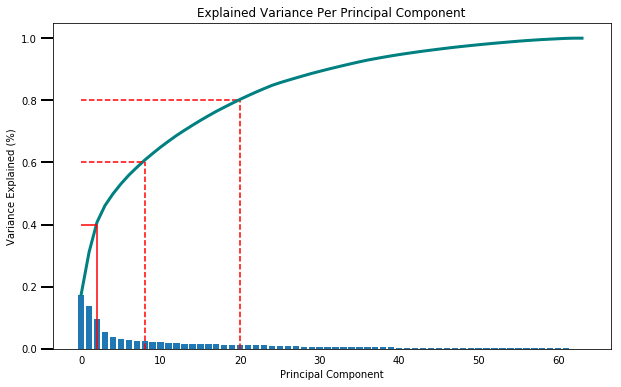

In [75]:
# Investigate the variance accounted for by each principal component.

def print_image(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.plot(ind, cumvals,color='teal',linewidth=3)
    plt.hlines(y=0.8, xmin=0, xmax=20, color='red', linestyles='dashed',zorder=1)
    plt.vlines(x=20, ymin=0, ymax=0.8, color='red', linestyles='dashed',zorder=2)
    plt.hlines(y=0.6, xmin=0, xmax=8, color='red', linestyles='dashed',zorder=3)
    plt.vlines(x=8, ymin=0, ymax=0.6, color='red', linestyles='dashed',zorder=4)
    plt.hlines(y=0.4, xmin=0, xmax=2, color='red', linestyles='-',zorder=5)
    plt.vlines(x=2, ymin=0, ymax=0.4, color='red', linestyles='-',zorder=6)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

print_image(pca)

In [734]:
# Re-apply PCA to the data while selecting for number of components to retain.

from sklearn.decomposition import PCA
pca = PCA(n_components=20)
azdias_pca = pca.fit_transform(azdias)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I choose the number of components as 20 is because you can see the curve, when the principal components is more or less 20, the variance explained % is around 80%. So let´s try it!

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [631]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

df=pd.DataFrame(pca.components_[0])
df.index=azdias.columns
df.columns=['weight']
df=df.sort_index(by=['weight'], ascending=False)
df.style.bar(align='mid',color=['#d65f5f', '#5fba7d'], width=100)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


,weight
FINANZ_SPARER,0.232921
SEMIO_REL,0.211495
SEMIO_PFLICHT,0.204533
Decade,0.20044
SEMIO_TRADV,0.188428
PLZ8_ANTG3,0.180545
PLZ8_ANTG4,0.173562
ORTSGR_KLS9,0.16822
FINANZ_UNAUFFAELLIGER,0.164081
EWDICHTE,0.163331


In [632]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df=pd.DataFrame(pca.components_[1])
df.index=azdias.columns
df.columns=['weight']
df=df.sort_index(by=['weight'], ascending=False)
df.style.bar(align='mid',color=['#d65f5f', '#5fba7d'], width=100)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  import sys


,weight
ORTSGR_KLS9,0.20263
EWDICHTE,0.199593
PLZ8_ANTG3,0.199499
PLZ8_ANTG4,0.187942
SEMIO_ERL,0.179658
ALTERSKATEGORIE_GROB,0.175503
FINANZ_HAUSBAUER,0.171706
Neighborhood,0.157752
Households_type,0.15707
FINANZ_VORSORGER,0.151695


In [633]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df=pd.DataFrame(pca.components_[2])
df.index=azdias.columns
df.columns=['weight']
df=df.sort_index(by=['weight'], ascending=False)
df.style.bar(align='mid',color=['#d65f5f', '#5fba7d'], width=100)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  import sys


,weight
SEMIO_VERT,0.343684
SEMIO_SOZ,0.260196
SEMIO_FAM,0.246152
SEMIO_KULT,0.230231
FINANZ_MINIMALIST,0.159063
RETOURTYP_BK_S,0.122175
FINANZ_VORSORGER,0.10587
ALTERSKATEGORIE_GROB,0.0898557
SEMIO_LUST,0.0796565
SEMIO_REL,0.0731487


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

### In the first group of components, we can see the below most relevant components, but they are all related with the house size, household income and the financial statement of one family.

**Most Positive componentes are: **

PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region 
Higher share of medium apartment buildings
PLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region 
Higher share of larger apartment buildings
HH_EINKOMMEN_SCORE: Estimated household net income 
Lower incomes

**Most Negative:**

FINANZ_MINIMALIST : Financial typology - MINIMALIST: low financial interest 
Lower financial minimalism
MOBI_REGIO : Movement patterns 
KBA05_ANTG1 : Number of 1-2 family houses in the microcell 

So we can assume that the family live in a place with bigger houses might have less financial problem.

### In the second group of components, we can see the below most relevant components, but they are all related with the age, generation and culture.

**Most Positive componentes are: **

ALTERSKATEGORIE_GROB: Estimated age based on given name analysis 
Older or evenly distributed
FINANZ_VORSORGER: Financial typology - Be prepared 
Lower financial preparation
SEMIO_ERL: Personality typology - event-oriented 
Lower event oriented affinity

**Most Negative:**

ALTER_HH: Birthdate of head of household
Decade: Generation of the household
GEBURTSJAHR:Year of birth

We can maybe say that the older people have less financial issue.

### In the third group of components, we can see the below most relevant components, but they are all related with the personality typology like socially-minded, critical minded, family minded

**Most Positive componentes are: **

SEMIO_VERT: Personality typology,  VERT: dreamful 
SEMIO_SOZ: Personality typology, SOZ: socially-minded
SEMIO_FAM: Personality typology, family-minded

**Most Negative:**

SEMIO_DOM: Personality typology - DOM: dominant-minded
SEMIO_KAEM: Personality typology - KAEM: combative attitude
ANREDE_KZ: Gender 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [735]:
from sklearn.cluster import KMeans

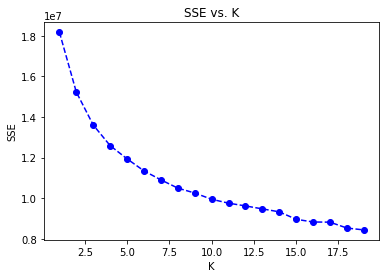

In [75]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores =[]

for center in range(1,20):
    kmeans =KMeans(center)
    model = kmeans.fit(azdias_pca)
    scores.append(abs(model.score(azdias_pca)))
    
centers = list(range(1,20))
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [736]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=10)
model = kmeans.fit(azdias_pca)
labels = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

This part, I am aim to create the basic Kmean cluster, and test the Kmean score, I set the number of clusters as 10 because when the clusters become 10, the decrease of SSE start to become more smooth. I fit the predict the file by using the Kmean Sklearn.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [721]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', ';')

In [722]:
customers.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


In [723]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_clean_data = clean_data(customers)[0]

Convert missing value codes into NaN, OK
Remove selected columns and rows, OK
Select, re-encode, and engineer column value, OK


In [724]:
customer_clean_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Households_type,Life_status,Neighborhood,Rural
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,5.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0,0.0,7.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,2.0,3.0,5.0,3.0,2.0,2.0,3.0,4.0,2.0,0.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0,0.0,7.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0,3.0,0.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,5.0,3.0,7.0,5.0,2.0,2.0,3.0,4.0,1.0,0.0


In [725]:
customer_clean_data.shape

(141719, 63)

In [739]:
customer_clean_data= customer_clean_data.dropna()

In [742]:
sum(customer_clean_data.isnull().sum())

0

In [743]:
customer_clean_data[customer_clean_data.columns] = scaler.transform(customer_clean_data[customer_clean_data.columns].as_matrix())

In [744]:
customers_clean_pca = pca.transform(customer_clean_data)

In [746]:
predict_customers = model.predict(customers_clean_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [747]:
azdias_clean_data1=np.full((azdias.shape[0],), -1)
azdias_clean_ready = np.concatenate([labels, azdias_clean_data1])


customer_clean_data1=np.full((customer_clean_data.shape[0],), -1)
customer_clean_ready = np.concatenate([predict_customers, customer_clean_data1])


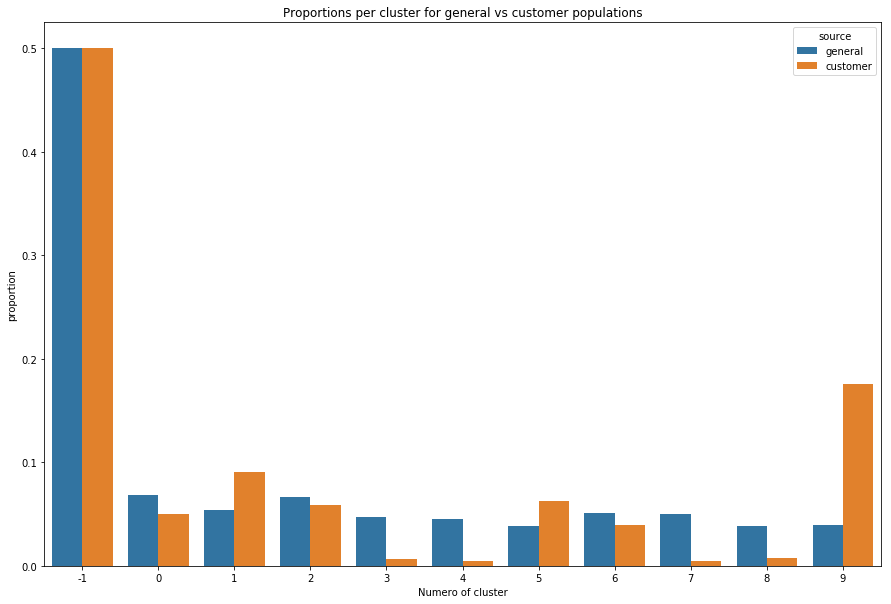

In [748]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

dict1 = {'proportion': pd.Series(azdias_clean_ready).value_counts(normalize=True, sort=False), 
          'source': 'general'}

general_proportions = pd.DataFrame(dict1)

dict2 = {'proportion': pd.Series(customer_clean_ready).value_counts(normalize=True, sort=False), 
          'source': 'customer'}

customer_proportions = pd.DataFrame(dict2)

total_proportions = pd.concat([general_proportions, customer_proportions])


fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(ax=ax, x=total_proportions.index, y = total_proportions.proportion, hue=total_proportions.source)
ax.set_xlabel('Numero of cluster')
ax.set_title('Proportions per cluster for general vs customer populations');

In [749]:
proportion_difference = customer_proportions['proportion'] - general_proportions['proportion']
positive= proportion_difference > 0

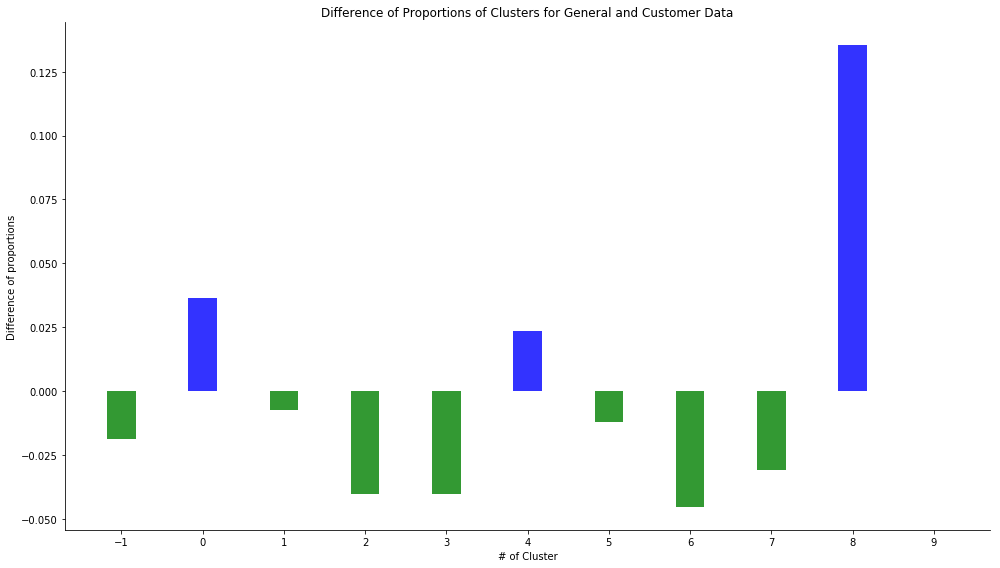

In [750]:
fig, ax = plt.subplots(figsize=(14, 8))
index = np.append([-1], np.arange(10))
bar_width = 0.35
opacity = 0.8
 
diff = plt.bar(index, proportion_difference, bar_width,
                 alpha=opacity,
                 color=np.vectorize({True: 'b', False: 'g'}.get)(positive)
              )

 
plt.xlabel('# of Cluster')
plt.ylabel('Difference of proportions')
plt.title('Difference of Proportions of Clusters for General and Customer Data')
plt.xticks(index)
 
plt.tight_layout()
sns.set(style="whitegrid")
sns.despine();

In [751]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

def plot_cluster_demographics(kmeans, azdias_pca, labels):
    pca_cluster = azdias_pca[labels == kmeans]
    
    standardized_features = pca.inverse_transform(pca_cluster)
    features_cluster = scaler.inverse_transform(standardized_features)

    features_cluster = pd.DataFrame(np.round(features_cluster), columns = azdias.columns)
    
    return features_cluster

In [752]:
print(azdias_pca)

[[  4.13362244e+00  -2.47437524e+00  -3.02456889e+00 ...,  -8.81324972e-01
    1.15170620e+00   4.99632007e-01]
 [ -7.15934886e-01   4.30910569e-01  -3.00878230e+00 ...,  -2.12002812e-01
   -1.08259314e+00  -1.17320436e+00]
 [ -4.42363221e+00   9.89151353e-01  -8.85672791e-01 ...,   1.16235893e+00
   -1.40397184e-03   3.86594842e-01]
 ..., 
 [ -1.47301293e+00  -3.63676596e+00  -3.25226749e+00 ...,   7.43096646e-01
   -2.57455132e-01  -8.50416907e-01]
 [  6.06309690e+00  -3.08719881e+00   2.32538089e+00 ...,  -1.44952136e-01
    4.82971868e-01   2.55982124e-01]
 [ -5.93771557e-01   9.20914642e-01   2.93784122e+00 ...,  -1.34423959e+00
    3.43136196e-01  -8.94203586e-02]]


In [753]:
def plot_cluster_demographics(kmeans, azdias_pca, labels):
    pca_cluster = azdias_pca[labels == kmeans]
    
    standardized_features = pca.inverse_transform(pca_cluster)
    features_cluster = scaler.inverse_transform(standardized_features)

    features_cluster = pd.DataFrame(np.round(features_cluster), columns = azdias.columns)
    
    fig, axs = plt.subplots(3,3, figsize=(18,10))
    sns.countplot(features_cluster['ALTERSKATEGORIE_GROB'], ax = axs[0,0])
    sns.countplot(features_cluster['ANREDE_KZ'], ax = axs[0,1])
    sns.countplot(features_cluster['FINANZ_MINIMALIST'], ax = axs[0,2])
    sns.countplot(features_cluster['FINANZ_SPARER'], ax = axs[1,0])
    sns.countplot(features_cluster['FINANZ_VORSORGER'], ax = axs[1,1])
    sns.countplot(features_cluster['FINANZ_ANLEGER'], ax = axs[1,2])
    sns.countplot(features_cluster['FINANZ_UNAUFFAELLIGER'], ax = axs[2,0])
    sns.countplot(features_cluster['FINANZ_HAUSBAUER'],ax = axs[2,1])
    sns.countplot(features_cluster['GREEN_AVANTGARDE'],ax = axs[2,2])
    plt.show();

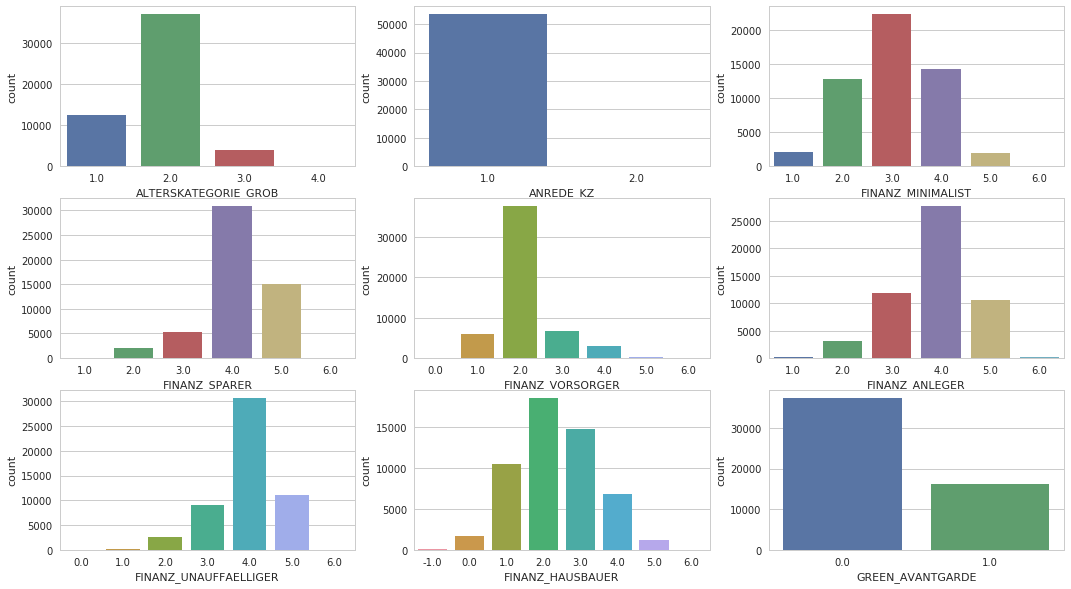

In [754]:
overrepresented=plot_cluster_demographics(8, azdias_pca, labels)

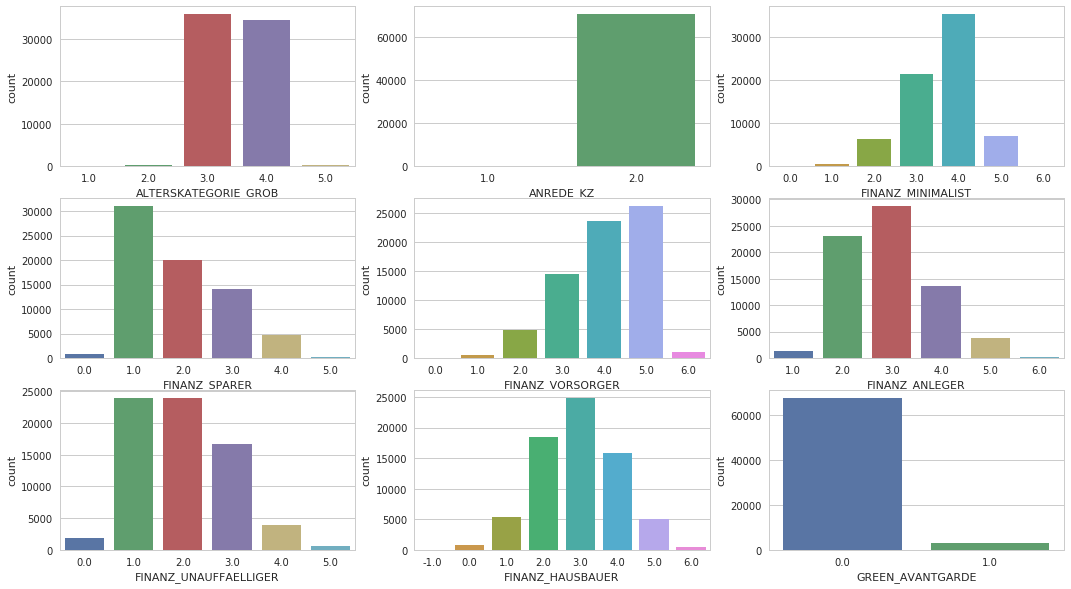

In [755]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented = plot_cluster_demographics(6, azdias_pca, labels)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Is not difficut to see from the graphs I have generated. From the first graph from part 3, I compared the 2 group, the customer_data and the genera_population data. The number of the cluster needed for each group is matching well, excpet the 5th cluster has the bigger difference of proportion for cluster. You can have a better view to see the difference of 2 groups of clusters in the second graph, which you can see the negative and positve difference.

In the second part of What kinds of people are part of a cluster that is underrepresented/overrepresented in the customer data compared to the general population. I choose the first 9 attrubutes wot see how do they performance in the different number of cluster. I choose the 8 and 6, because these 2 group of clusters give the biggst postive and negative difference between customer data and the general population data. As we can see in these 2 groups of graphs, to see which group are the part of underrepresented/overrepresented in the customer data compared to the general population.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.